In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import scrublet as scr
import os
import warnings
import functools
import seaborn as sns
import scipy.stats
import anndata
import dandelion as ddl
sc.logging.print_header()

warnings.filterwarnings('ignore')
os.chdir('/lustre/scratch117/cellgen/team297/kt16/Ziad/scanpy')

scanpy==1.7.1 anndata==0.7.5 umap==0.5.1 numpy==1.19.4 scipy==1.6.0 pandas==1.2.3 scikit-learn==0.23.2 statsmodels==0.12.1 python-igraph==0.8.3 leidenalg==0.8.3


In [2]:
rna = sc.read_h5ad('h5ad/adata_soupx_trans_cite_rna.h5ad')

In [3]:
sorted(list(set(rna.obs['fine_clustering'])))

['B_naive',
 'B_non-switched_memory',
 'B_switched_memory',
 'CD16neg_NK',
 'CD16pos_NK',
 'CD16pos_SIGLEC7_NK',
 'CD4_CD25_IL17RB_T/NKT',
 'CD4_Tcm',
 'CD4_Tem',
 'CD4_Tnaive',
 'CD4_Treg',
 'CD8_Tem',
 'CD8_Temra',
 'CD8_Tnaive',
 'Classical_mono',
 'Erythrocyte',
 'HSC',
 'Intermediate_mono',
 'MAIT',
 'Megakaryocyte',
 'NKT',
 'Non-classical_mono',
 'Non-classical_mono_C1Q+',
 'Plasmablast',
 'Proliferating_lymphocyte',
 'Vd1_gdT',
 'Vd2_gdT',
 'cDC1',
 'cDC2',
 'doublets',
 'pDC']

In [21]:
## MNP

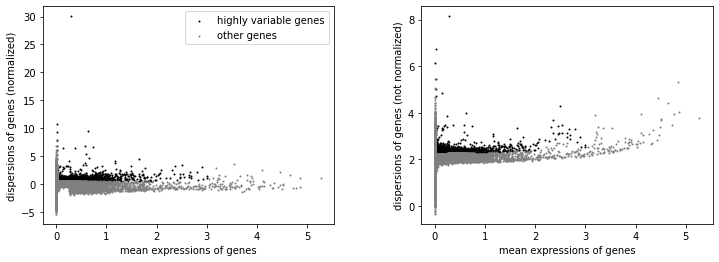

In [4]:
# subset to the T and NK cells
rnax = rna[(rna.obs['fine_clustering'].isin(['Classical_mono',
 'Intermediate_mono',
 'Non-classical_mono',
 'Non-classical_mono_C1Q+',
 'cDC1',
 'cDC2',
 'pDC']))].raw.to_adata().copy()
# Identify highly-variable genes
sc.pp.highly_variable_genes(rnax, min_mean = 0.0125, max_mean = 3, min_disp = 0.5)
## remove TRBV/TRAV and IGHV/IGLV/IGKV from the highly variable genes
sc.pl.highly_variable_genes(rnax)
# stash the normalized data in raw
rnax.raw = rnax
# filter to only highly variable
rnax = rnax[:, rnax.var['highly_variable']]

In [5]:
import multiprocessing
# regress and scale for PCA
sc.pp.regress_out(rnax, ['total_counts', 'pct_counts_mt'], n_jobs = multiprocessing.cpu_count()-1)
sc.pp.scale(rnax, max_value = 10)
sc.tl.pca(rnax, svd_solver = 'arpack')

In [6]:
# run harmony. compute the neighborhood graph.
sc.external.pp.harmony_integrate(rnax, key='study_id')
sc.pp.neighbors(rnax, use_rep = 'X_pca_harmony')

2021-03-25 12:39:04,826 - harmonypy - INFO - Iteration 1 of 10
2021-03-25 12:39:46,323 - harmonypy - INFO - Iteration 2 of 10
2021-03-25 12:40:28,193 - harmonypy - INFO - Converged after 2 iterations


In [7]:
# run UMAP
sc.tl.umap(rnax, min_dist = 0.3)

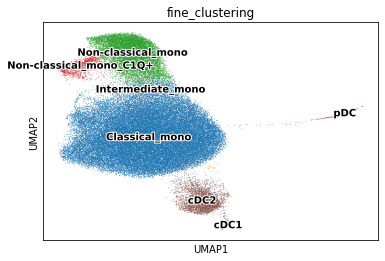

In [8]:
# find clusters
sc.pl.umap(rnax, color=['fine_clustering'], legend_loc ='on data', legend_fontoutline=2)

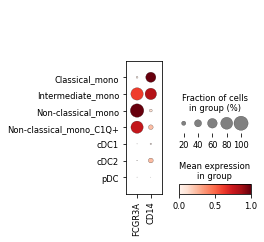

In [9]:
sc.pl.dotplot(rnax, ['FCGR3A', 'CD14'], groupby = 'fine_clustering', standard_scale='var')

In [10]:
# will overwrite later
mono = sc.read_h5ad('h5ad/classical_mono_rna.h5ad')
rnax.obs['test'] = rnax.obs['fine_clustering']
rnax.obs['test'] = rnax.obs['test'].astype('object')
rnax.obs['test'].update(mono.obs['leiden_mono'])

... storing 'test' as categorical


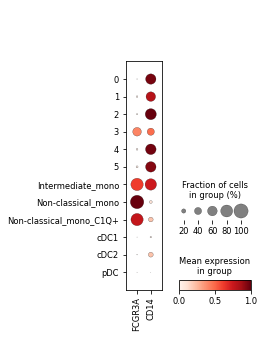

In [11]:
sc.pl.dotplot(rnax, ['FCGR3A', 'CD14'], groupby = 'test', standard_scale='var')

In [12]:
# so it looks like #3 should be intermediate mono. update all the files
newdict = {'0':'Classical_mono','1':'Classical_mono','2':'Classical_mono','3':'Intermediate_mono','4':'Classical_mono','5':'Classical_mono'}
mono.obs['fine_clustering'] = [newdict[l] for l in mono.obs['leiden_mono']]

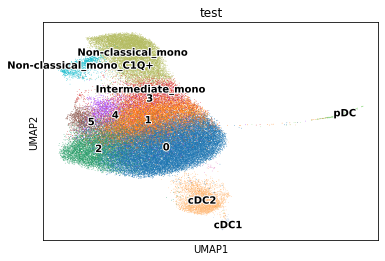

In [21]:
sc.pl.umap(rnax, color=['test'], legend_loc ='on data', legend_fontoutline=2)

In [3]:
# rna = sc.read_h5ad('h5ad/adata_soupx_trans_cite_rna.h5ad')
adata = sc.read_h5ad('h5ad/adata_soupx_trans_cite_raw.h5ad')
adata2 = sc.read_h5ad('h5ad/adata_soupx_trans_raw.h5ad')
adata3 = sc.read_h5ad('h5ad/adata_soupx_trans_cite_bgshift_raw.h5ad')

In [14]:
rna.obs['fine_clustering'].update(mono.obs['fine_clustering'])

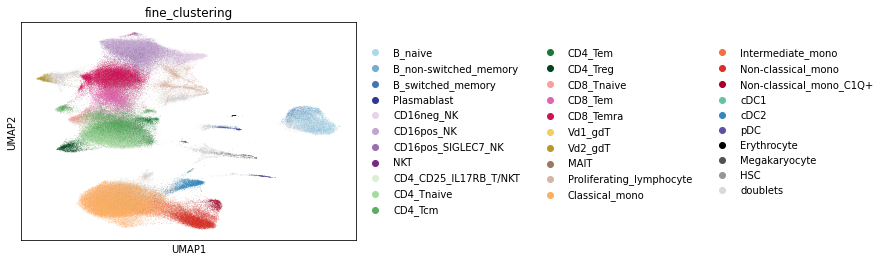

In [12]:
rna.obs['fine_clustering'] = rna.obs['fine_clustering'].cat.reorder_categories(['B_naive', 'B_non-switched_memory', 'B_switched_memory', 'Plasmablast', 'CD16neg_NK', 'CD16pos_NK', 'CD16pos_SIGLEC7_NK', 'NKT', 'CD4_CD25_IL17RB_T/NKT', 'CD4_Tnaive', 'CD4_Tcm', 'CD4_Tem', 'CD4_Treg', 'CD8_Tnaive', 'CD8_Tem', 'CD8_Temra', 'Vd1_gdT', 'Vd2_gdT', 'MAIT', 'Proliferating_lymphocyte',  'Classical_mono', 'Intermediate_mono', 'Non-classical_mono', 'Non-classical_mono_C1Q+', 'cDC1', 'cDC2', 'pDC', 'Erythrocyte', 'Megakaryocyte', 'HSC', 'doublets'])
sc.pl.umap(rna, color = 'fine_clustering', palette = {'B_naive':'#abd9e9',
'B_non-switched_memory':'#74add1',
'B_switched_memory':'#4575b4',
'Plasmablast':'#313695',
'CD16neg_NK':'#e7d4e8',
'CD16pos_NK':'#c2a5cf',
'CD16pos_SIGLEC7_NK':'#9970ab',
'NKT':'#762a83',
'CD4_CD25_IL17RB_T/NKT':'#d9f0d3',
'CD4_Tnaive':'#a6dba0',
'CD4_Tcm':'#5aae61',
'CD4_Tem':'#1b7837',
'CD4_Treg':'#00441b',
'CD8_Tnaive':'#ff9d9a',
'CD8_Tem':'#df65b0',
'CD8_Temra':'#ce1256',
'Vd1_gdT':'#f1ce63',
'Vd2_gdT':'#b6992d',
'MAIT':'#9d7763',
'Proliferating_lymphocyte':'#d7b5a6',
'Classical_mono':'#fdae61',
'Intermediate_mono':'#f46d43',
'Non-classical_mono':'#d73027',
'Non-classical_mono_C1Q+':'#a50026',
'cDC1':'#66c2a5',
'cDC2':'#3288bd',
'pDC':'#5e4fa2',
'Erythrocyte':'#000000',
'Megakaryocyte':'#525252',
'HSC':'#969696',
'doublets':'#d9d9d9'})

In [13]:
adata.obs = rna.obs.copy()
adata2.obs = rna.obs.copy()
adata3.obs = rna.obs.copy()

adata.uns = rna.uns.copy()
adata2.uns = rna.uns.copy()
adata3.uns = rna.uns.copy()

In [14]:
# save first
rna.write('h5ad/adata_soupx_trans_cite_rna.h5ad', compression = 'gzip')
adata.write('h5ad/adata_soupx_trans_cite_raw.h5ad', compression = 'gzip')
adata2.write('h5ad/adata_soupx_trans_raw.h5ad', compression = 'gzip')
adata3.write('h5ad/adata_soupx_trans_cite_bgshift_raw.h5ad', compression = 'gzip')

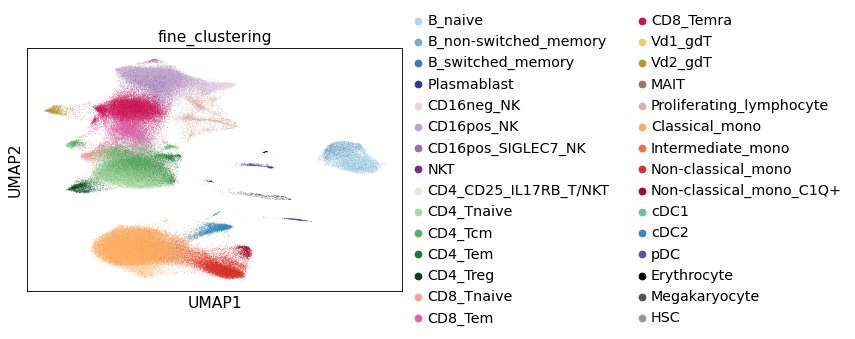

In [15]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

sc.set_figure_params(figsize = (6,4), dpi_save = 900, vector_friendly=True)
sc.pl.umap(rna[~(rna.obs['fine_clustering'] == 'doublets')], color = 'fine_clustering', save = '_fine_clustering.pdf')

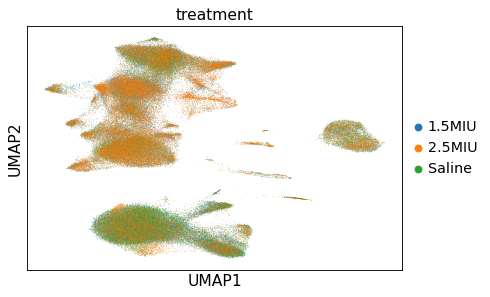

In [16]:
sc.pl.umap(rna[~(rna.obs['fine_clustering'] == 'doublets')], color = 'treatment', save = '_treatment.pdf')

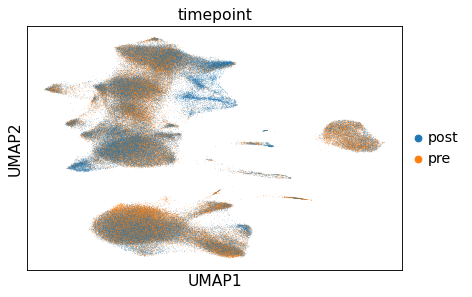

In [17]:
sc.pl.umap(rna[~(rna.obs['fine_clustering'] == 'doublets')], color = 'timepoint', save = '_timepoint.pdf')

In [2]:
import numpy as np
import pandas as pd
import scanpy as sc
import scrublet as scr
import os
import warnings
import functools
import seaborn as sns
import scipy.stats
import anndata
import dandelion as ddl
sc.logging.print_header()

warnings.filterwarnings('ignore')
os.chdir('/lustre/scratch117/cellgen/team297/kt16/Ziad/scanpy')

rna = sc.read_h5ad('h5ad/adata_soupx_trans_cite_rna.h5ad')
rnax = rna[~(rna.obs['fine_clustering'] == 'doublets')].copy()

scanpy==1.7.1 anndata==0.7.5 umap==0.5.1 numpy==1.19.4 scipy==1.6.0 pandas==1.2.3 scikit-learn==0.23.2 statsmodels==0.12.1 python-igraph==0.8.3 leidenalg==0.8.3


In [8]:
rnax.obs.drop('CD4', axis = 1, inplace = True)

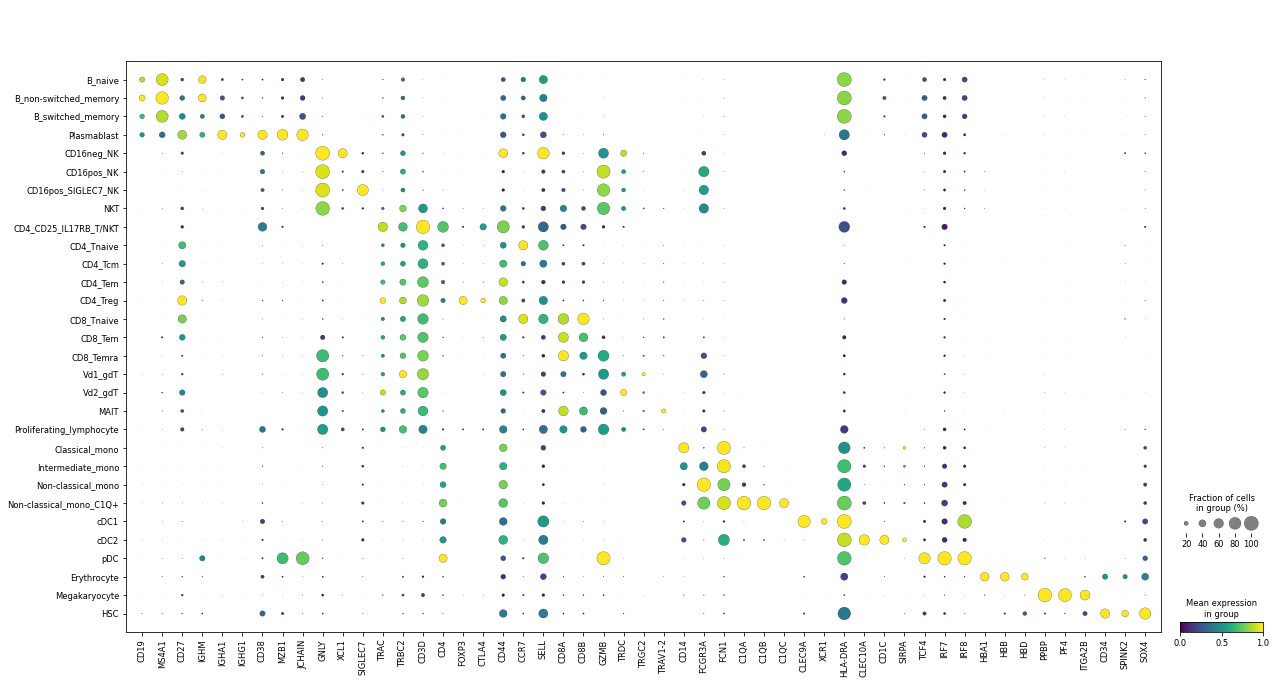

In [48]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
sc.pl.dotplot(rnax, 
              ['CD19', 'MS4A1', 'CD27', 
               'IGHM', 'IGHA1', 'IGHG1',
               'CD38', 'MZB1', 'JCHAIN',
               'GNLY', 'XCL1', 'SIGLEC7',
               'TRAC', 'TRBC2', 'CD3D', 
               'CD4', 'FOXP3', 'CTLA4', 
               'CD44', 'CCR7', 'SELL', 
               'CD8A', 'CD8B', 'GZMB',
               'TRDC', 'TRGC2', 'TRAV1-2',
               'CD14', 'FCGR3A', 'FCN1',
               'C1QA', 'C1QB', 'C1QC', 
               'CLEC9A', 'XCR1', 'HLA-DRA',
               'CLEC10A', 'CD1C', 'SIRPA',
               'TCF4', 'IRF7', 'IRF8', 
               'HBA1', 'HBB', 'HBD',
               'PPBP', 'PF4', 'ITGA2B',
               'CD34', 'SPINK2', 'SOX4'], 
              groupby = 'fine_clustering', 
              color_map = 'viridis', 
              standard_scale = 'var', 
              save = 'markers.pdf')